In [130]:
import torch
import os
import torchvision
from torch.utils.data import Dataset, Subset, DataLoader
from pycocotools.coco import COCO
import numpy as np

DATAPATH = '/mnt/NeuralNetworksDL/coco/'
GRAYS = [498856, 6432, 84582, 457741, 11801, 427401, 821, 225717, 118895, 325387, 217886, 575029,
578250, 81003, 100896, 150354, 476888, 436984, 122051, 155083, 156878, 61048, 105872,
233263, 406404, 416869, 518025, 343009, 416372, 140627, 207339, 5294, 300200, 72098, 492325,
507794, 211867, 577207, 249711, 173610, 563447, 257178, 525513, 221691, 154053, 470442, 296884,
104124, 32405, 384907, 394322, 176397, 85407, 491058, 389984, 560349, 434837, 220770, 451074, 86,
406011, 406744, 134071, 269858, 410498, 53756, 46433, 363331, 280731, 140623, 204792, 80906, 33127,
132791, 228474, 571415, 361221, 208206, 342051, 349069, 377984, 155954, 451095, 532787, 573179,
155811, 27412, 124694, 336668, 577265, 185639, 103499, 532919, 510587, 145288, 559665, 176483, 342921,
64270, 123539, 205782, 205486, 57978, 353952, 312288, 397575, 439589, 431115, 126531, 287422,
555583, 173081, 380088, 401901, 579138, 260962, 166522, 426558, 421195, 361516, 390663, 15236, 30349,
107450, 385625, 29275, 443909, 250239, 134206, 226585, 518951, 131942, 1350, 93120, 509358, 561842, 131366,
386204, 268036, 217341, 6379, 549879, 564314, 111109, 434765, 35880, 381270, 330736, 384693, 39068, 18702,
316867, 186888, 264165, 389206, 15286, 445845, 58517, 470933, 33352, 210847, 458073, 377837, 293833,
25404, 95753, 270925, 463454, 443689, 213280, 563376, 77709, 243205, 313608, 210175, 566596, 60060,
259284, 263002, 576700, 484742, 66642, 341892, 400107, 394547, 12345, 75052, 39790, 369966, 134918,
505962, 39900, 179405, 34861, 220898, 450674, 223616, 454000, 540378, 3293, 492395, 249835, 429633,
520479, 579239, 537427, 449901, 358281, 384910, 494273, 140092, 321897, 347111, 571503, 503640, 64332,
421613, 113929, 10125, 8794, 107962, 496444, 480482, 264753, 87509, 40428, 517899]
COCO_CLASSES = {'person': 1,'bicycle': 2,'car': 3,'motorcycle': 4,'airplane': 5,'bus': 6,
                'train': 7,'truck': 8,'boat': 9,'traffic light': 10,'fire hydrant': 11,
                'stop sign': 13,'parking meter': 14,'bench': 15,'bird': 16,'cat': 17,'dog': 18,
                'horse': 19,'sheep': 20,'cow': 21,'elephant': 22,'bear': 23,'zebra': 24,
                'giraffe': 25,'backpack': 27,'umbrella': 28,'handbag': 31,'tie': 32,
                'suitcase': 33,'frisbee': 34,'skis': 35,'snowboard': 36,'sports ball': 37,
                'kite': 38,'baseball bat': 39,'baseball glove': 40,'skateboard': 41,
                'surfboard': 42,'tennis racket': 43,'bottle': 44,'wine glass': 46,'cup': 47,
                'fork': 48,'knife': 49,'spoon': 50,'bowl': 51,'banana': 52,'apple': 53,
                'sandwich': 54,'orange': 55,'broccoli': 56,'carrot': 57,'hot dog': 58,'pizza': 59,
                'donut': 60,'cake': 61,'chair': 62,'couch': 63,'potted plant': 64,'bed': 65,
                'dining table': 67,'toilet': 70,'tv': 72,'laptop': 73,'mouse': 74,'remote': 75,
                'keyboard': 76,'cell phone': 77,'microwave': 78,'oven': 79,'toaster': 80,'sink': 81,
                'refrigerator': 82,'book': 84,'clock': 85,'vase': 86,'scissors': 87,
                'teddy bear': 88,'hair drier': 89,'toothbrush': 90}


In [131]:
# https://discuss.pytorch.org/t/dataloader-collate-fn-throws-runtimeerror-stack-expects-each-tensor-to-be-equal-size-in-response-to-variable-number-of-bounding-boxes/117952
def my_collate(batch):
    return tuple(zip(*batch))

class CocoDataSet(Dataset):
    def __init__(self, annt_file, data_dir=DATAPATH, cats=None, size=10000, transform=None, fetch_type='intersection'):
        self.data_dir = data_dir
        self.transform = transform
        coco = COCO(data_dir + 'annotations/' + annt_file)
        self.cats = {k: idx for idx, k in enumerate([COCO_CLASSES[cat] for cat in cats])}
        print('Categories:', self.cats)
        catIds = coco.getCatIds(catNms=cats)
        if fetch_type == 'intersection' or len(cats) <= 1:
            imgIds = coco.getImgIds(catIds=catIds)
        elif fetch_type == 'union':
            imgIds = []
            for cat in catIds:
                temp = coco.getImgIds(catIds=cat)
                imgIds += [x for x in temp if x not in imgIds]
        else:
            raise ValueError('Must fetch image intersection or union for multiple categories')
        self.ids = [x for x in imgIds if x not in GRAYS]
        annIds = coco.getAnnIds(imgIds=self.ids, catIds=catIds, iscrowd=None)
        anns = coco.loadAnns(annIds)
        self.labels = {x: [] for x in self.ids}
        self.boxes = {x: [] for x in self.ids}
        for d in anns:
            self.boxes[d['image_id']].append(d['bbox'])
            self.labels[d['image_id']].append(self.cats[d['category_id']])
        if size > len(self.ids):
            self.size = len(self.ids)
        else:
            for k in self.ids[size:]:
                self.boxes.pop(k, None)
            self.ids = self.ids[:size]
            self.size = size
        print('Dataset size:', self.size)

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        # __getitem__ actually reads the img content
        image = torchvision.io.read_image(self.data_dir + '{:012}'.format(self.ids[index]) + '.jpg').to(torch.float32) / 255
        target = {'boxes': len(self.boxes[self.ids[index]]) * [4 * [None]]}
        for box_idx, box in enumerate(self.boxes[self.ids[index]]):
            # relative box coordinates w.r.t image size so that they transform accordingly
            target['boxes'][box_idx] = (box[0] / image.shape[2], box[1] / image.shape[1],
                                        box[2] / image.shape[2], box[3] / image.shape[1])
        # one-hot encoding
        target['labels'] = np.eye(len(self.cats))[self.labels[self.ids[index]]] 
        if self.transform:
            image = self.transform(image)
        return image, target



def load_coco_dataset(batch_size=64, cats=None, size=10000, dim=64, fetch_type='intersection'):
    # ImageNet normalization, Resizing to dim x dim
    data = CocoDataSet('instances_train2017.json',
                       cats=cats,
                       data_dir=DATAPATH,
                       size=size,
                       fetch_type=fetch_type,
                       transform=torchvision.transforms.Compose([
                           torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                           torchvision.transforms.Resize((dim, dim))]))
    n_val = int(0.1 * len(data)) + 1
    idx = torch.randperm(len(data))
    train_dataset = Subset(data, idx[:-n_val])
    valid_dataset = Subset(data, idx[-n_val:])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=my_collate)
    return train_loader, valid_loader


In [132]:
import matplotlib.pyplot as plt
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
mean = [-1 * x / y for x, y in zip(mean, std)]
std = [1 / x for x in std]
unnormalize = torchvision.transforms.Normalize(mean=mean, std=std)
train_loader, valid_loader = load_coco_dataset(batch_size=32, cats=('dog', 'cat'), size=10000, dim=256,
                                              fetch_type='union')

loading annotations into memory...
Done (t=14.56s)
creating index...
index created!
Categories: {18: 0, 17: 1}
Dataset size: 8279


74.83200000000001 134.89600000000002 159.45600000000002 92.26
106.43733333333333 100.196 93.22666666666667 42.392
[[1. 0.]
 [1. 0.]]


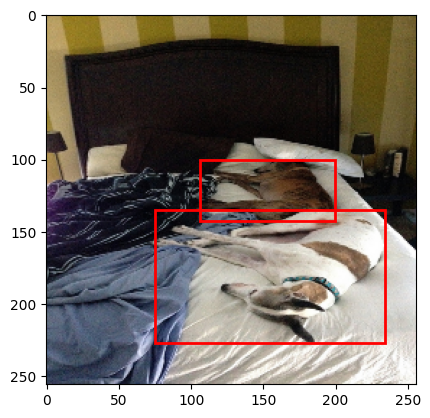

In [145]:
from matplotlib import patches

# https://stackoverflow.com/a/37437395
for imgs, targets in train_loader:
    if len(targets[0]['boxes']) < 2:
        continue
    fig, ax = plt.subplots()
    img = imgs[0]
    target = targets[0]
    ax.imshow(unnormalize(img).permute(1, 2, 0))
    for idx, box in enumerate(target['boxes']):
        x = box[0] * img.shape[2]
        y = box[1] * img.shape[1]
        width = box[2] * img.shape[2]
        height = box[3] * img.shape[1]
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor="r", fill=False)
        print(x, y,  width, height)
        ax.add_patch(rect)
    print(target['labels'])
    plt.show()
    break
